## Position V2 - Streamlined Pose Estimation Pipeline


### Overview


_Developer Note:_ if you may make a PR in the future, be sure to copy this
notebook, and use the `gitignore` prefix `temp` to avoid future conflicts.

This is one notebook in a multi-part series on Spyglass.

- To set up your Spyglass environment and database, see
  [the Setup notebook](./00_Setup.ipynb)
- For additional info on DataJoint syntax, including table definitions and
  inserts, see
  [the Insert Data notebook](./02_Insert_Data.ipynb)
- For the legacy V1 DLC pipeline, see
  [the DLC notebook](./21_DLC.ipynb)

**Position V2** is designed to expand the functionality of the V1 pipeline
while simplifying the number of tables. The V2 pipeline:

- **Reduces complexity**: 4 main tables instead of 10+
- **Multi-tool support**: Works with DLC, SLEAP, and any ndx-pose compatible tool
- **Flexible workflows**: Import pre-trained models or train new ones
- **NWB-native storage**: Uses ndx-pose extension for standardized data
- **Simplified processing**: Single PoseV2 table handles all position processing

This tutorial will walk through:

- Importing a trained model (DLC or ndx-pose)
- Running pose estimation on videos
- Processing pose data (orientation, centroid, smoothing)
- Retrieving and visualizing results


[2026-02-03 12:10:47,394][INFO]: DataJoint is configured from /home/cb/wrk/spyglass/pv2/dj_local_conf.json


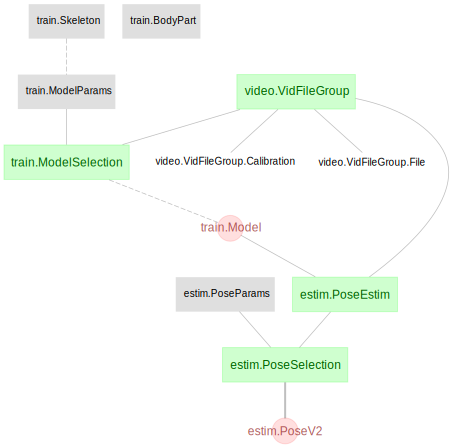

In [ ]:
import datajoint as dj 

dj.config.load('../dj_local_conf.json') # TODO: REMOVE BEFORE MERGE

from spyglass.position.v2 import video, train, estim

dj.Diagram(video) + dj.Diagram(train) + dj.Diagram(estim)

### Table of Contents<a id='TableOfContents'></a>

- [`BodyParts`](#BodyParts)
- [`Model`](#Model)
- [`PoseEstim`](#PoseEstim)
- [`PoseParams`](#PoseParams)
- [`PoseV2`](#PoseV2)
- [`Fetching Data`](#FetchData)
- [`Visualization`](#Visualization)
- [`V1 vs V2 Comparison`](#Comparison)


### Imports


In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from spyglass.position.v2 import (
    BodyPart,
    Model,
    PoseEstim,
    PoseParams,
    PoseV2,
    Skeleton,
)

# ignore datajoint+jupyter async warnings
import warnings

warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)

## Path 1: Import Existing Model


### [Model](#TableOfContents) <a id="Model"></a>


For most experiments, you'll start with an existing trained model rather than
training from scratch. Position V2 supports different import methods:

1. **DLC config.yaml**: Import models trained with DeepLabCut
2. **NWB file**: Import models from any ndx-pose compatible tool
3. **SLEAP config**: `NotYetImplemented`

Let's start by looking at the Model table:


In [5]:
Model()

model_id,model_params_id,tool,vid_group_id,analysis_file_name name of the file,model_path


#### Import from DeepLabCut Project

If you have a DeepLabCut model already trained, you can import it by changing
the following to the path to your `config.yaml`. If not, use the following
codeblock to download and set up an example project.

```bash
cd /your/desired/path
git clone https://github.com/DeepLabCut/DeepLabCut/
python ./DeepLabCut/examples/testscript.py
```

In [7]:
# Point to your DLC project config file
dlc_path = Path.home() / "DeepLabCut"
dlc_path = Path.home() / "wrk" / "alt" / "DeepLabCut" # TODO: REMOVE BEFORE MERGE
config_path = dlc_path / "examples" / "TEST-Alex-2025-09-08" / "config.yaml"

# Import the model
if config_path.exists():
    model_key = Model().import_model(config_path)
    print(f"Imported model: {model_key}")
else:
    print(f"Config not found at {config_path}")
    print("Adjust the path or run testscript.py to create example project")

TypeError: Table.insert() got an unexpected keyword argument 'raise_on_duplicate'

The import process:

1. Detects the latest trained model snapshot
2. Extracts the skeleton (bodyparts and connections)
3. Creates entries in Skeleton and ModelParams tables
4. Stores model metadata in an NWB file
5. Creates a Model entry for inference

Let's verify the import:


In [ ]:
# Check the model entry
Model() & model_key

In [ ]:
# Check the associated skeleton
Skeleton() & model_key

#### Import from NWB File


If you have pose estimation data from DLC, SLEAP, or another tool stored in
NWB format using ndx-pose, you can import it:

```python
nwb_path = "/path/to/pose_estimation.nwb"
model_key = Model().import_model(nwb_path)
```

This is useful for:
- Importing models from collaborators
- Using models trained with SLEAP
- Working with pre-processed data


### [PoseEstim](#TableOfContents) <a id="PoseEstim"></a>


Now that we have a model, let's run pose estimation on a video.


#### Option A: Load existing DLC output


If you've already run DLC inference and have the output files:


In [ ]:
# Example: Load existing DLC h5/csv files into NWB
# dlc_output = "/path/to/video_DLC_resnet50_project100000.h5"
# nwb_file = "analysis_20250106.nwb"
#
# PoseEstim.load_dlc_output(
#     dlc_output_path=dlc_output,
#     nwb_file_name=nwb_file
# )

#### Option B: Run inference with Spyglass


To run inference on a new video:


In [ ]:
# Specify your video file
video_path = Path.home() / "videos" / "example_video.mp4"

# Run inference
if video_path.exists():
    output_path = Model().run_inference(
        model_key,
        video_path=str(video_path),
        save_as_csv=True,  # Also save as CSV for inspection
        device="cuda",  # Use GPU if available, otherwise "cpu"
    )

    print(f"Inference complete: {output_path}")

    # Load the results into NWB
    nwb_file = PoseEstim.load_dlc_output(
        dlc_output_path=output_path, nwb_file_name="analysis_20250106.nwb"
    )

    print(f"Loaded into NWB: {nwb_file}")
else:
    print(f"Video not found: {video_path}")

#### Fetching Pose Estimation Data


After running inference, we can fetch the raw pose data:


In [ ]:
# Get the PoseEstim entry
pose_estim_key = {**model_key, "analysis_file_name": "analysis_20250106.nwb"}

# Fetch as DataFrame
pose_df = (PoseEstim() & pose_estim_key).fetch1_dataframe()

# The DataFrame has MultiIndex columns: [scorer, bodypart, coords]
print(pose_df.head())

# Plot raw detections
bodypart = "nose"  # Choose a bodypart from your model
plt.figure(figsize=(10, 8))
plt.scatter(
    pose_df[("scorer", bodypart, "x")],
    pose_df[("scorer", bodypart, "y")],
    c=pose_df[("scorer", bodypart, "likelihood")],
    cmap="viridis",
    s=1,
    alpha=0.5,
)
plt.xlabel("X position (pixels)")
plt.ylabel("Y position (pixels)")
plt.title(f"{bodypart} raw detections")
plt.colorbar(label="Likelihood")
plt.gca().invert_yaxis()  # Image coordinates: (0,0) is top-left
plt.show()

### [PoseParams](#TableOfContents) <a id="PoseParams"></a>


Before processing pose data, we need to define processing parameters.
PoseParams stores configuration for:

- **Orientation**: How to calculate head direction
- **Centroid**: How to combine bodyparts into a single position
- **Smoothing**: How to interpolate and smooth the trajectory


#### View Available Parameter Sets


In [ ]:
PoseParams()

#### Use Default Parameters


For 2-LED tracking (common Frank Lab setup):


In [ ]:
PoseParams.insert_default(skip_duplicates=True)
params_key = {"pose_params": "default"}

For 4-LED tracking:

```python
PoseParams.insert_4LED_default(skip_duplicates=True)
params_key = {"pose_params": "4LED_default"}
```

For single marker tracking:

```python
PoseParams.insert_single_LED(skip_duplicates=True)
params_key = {"pose_params": "single_LED"}
```


#### Create Custom Parameters


For custom tracking scenarios:


In [ ]:
PoseParams.insert_custom(
    params_name="tutorial_custom",
    orient={
        "method": "two_pt",  # Use two points to define orientation
        "bodypart1": "nose",
        "bodypart2": "tail_base",
        "interpolate": True,
        "smooth": True,
    },
    centroid={
        "method": "1pt",  # Use single point as centroid
        "points": {"point1": "nose"},
    },
    smoothing={
        "interpolate": True,
        "interp_params": {
            "max_pts_to_interp": 10,
            "max_cm_to_interp": 15.0,
        },
        "smooth": True,
        "smoothing_params": {
            "method": "moving_avg",
            "smoothing_duration": 0.3,  # 300ms window
        },
        "likelihood_thresh": 0.95,
    },
    skip_duplicates=True,
)

Inspect the parameters:


In [ ]:
(PoseParams() & {"pose_params": "tutorial_custom"}).fetch1()

### [PoseV2](#TableOfContents) <a id="PoseV2"></a>


Now we can process the pose estimation to get cleaned, smoothed position data.


#### Create Processing Selection


In [ ]:
# Combine PoseEstim, PoseParams, and VidFileGroup
pose_v2_key = {
    **pose_estim_key,
    **params_key,
}

# Insert into PoseV2Selection (if using selection table pattern)
# Or directly populate PoseV2
PoseV2().populate(pose_v2_key)

The PoseV2.make() pipeline performs:

1. **Likelihood filtering**: Remove low-confidence detections
2. **Orientation calculation**: Compute head direction
3. **Centroid calculation**: Combine bodyparts into position
4. **Interpolation**: Fill gaps in tracking
5. **Smoothing**: Remove jitter from trajectories
6. **Velocity calculation**: Compute speed
7. **NWB storage**: Save results in standardized format


#### Verify Results


In [ ]:
PoseV2() & pose_v2_key

### [Fetching Data](#TableOfContents) <a id="FetchData"></a>


PoseV2 provides two methods for retrieving processed data:


#### Method 1: fetch1_dataframe()


Get cleaned data as a pandas DataFrame:


In [ ]:
processed_df = (PoseV2() & pose_v2_key).fetch1_dataframe()

print(processed_df.head())
print(f"\nColumns: {list(processed_df.columns)}")
print(
    f"Time range: {processed_df.index[0]:.2f} - {processed_df.index[-1]:.2f} s"
)
print(f"Mean speed: {processed_df['velocity'].mean():.2f} cm/s")

#### Method 2: fetch_obj()


Get raw pynwb objects for advanced analysis:


In [ ]:
# Fetch all objects
objs = (PoseV2() & pose_v2_key).fetch_obj()

# Or fetch specific objects
orient_obj = (PoseV2() & pose_v2_key).fetch_obj("orient")
centroid_obj = (PoseV2() & pose_v2_key).fetch_obj(["centroid", "velocity"])

print(f"Available objects: {list(objs.keys())}")
print(f"Centroid object: {objs['centroid']}")

### [Visualization](#TableOfContents) <a id="Visualization"></a>


Let's visualize the processed position data:


#### Trajectory Plot


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot trajectory colored by speed
scatter = ax.scatter(
    processed_df["position_x"],
    processed_df["position_y"],
    c=processed_df["velocity"],
    cmap="viridis",
    s=5,
    alpha=0.6,
)

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Animal trajectory (colored by speed)")
ax.axis("equal")
ax.invert_yaxis()  # Match video coordinates
plt.colorbar(scatter, label="Speed (cm/s)", ax=ax)
plt.show()

#### Time Series Plot


In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Position over time
axes[0].plot(
    processed_df.index, processed_df["position_x"], label="X", alpha=0.7
)
axes[0].plot(
    processed_df.index, processed_df["position_y"], label="Y", alpha=0.7
)
axes[0].set_ylabel("Position (cm)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Orientation over time
axes[1].plot(processed_df.index, np.rad2deg(processed_df["orientation"]))
axes[1].set_ylabel("Orientation (degrees)")
axes[1].grid(True, alpha=0.3)

# Speed over time
axes[2].plot(processed_df.index, processed_df["velocity"])
axes[2].set_ylabel("Speed (cm/s)")
axes[2].set_xlabel("Time (s)")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Quiver Plot (Orientation Arrows)


In [ ]:
# Subsample for clarity
step = len(processed_df) // 50
subsampled = processed_df.iloc[::step]

fig, ax = plt.subplots(figsize=(12, 10))

# Plot trajectory
ax.plot(
    processed_df["position_x"],
    processed_df["position_y"],
    "gray",
    alpha=0.3,
    linewidth=0.5,
)

# Add orientation arrows
arrow_length = 10  # cm
ax.quiver(
    subsampled["position_x"],
    subsampled["position_y"],
    arrow_length * np.cos(subsampled["orientation"]),
    arrow_length * np.sin(subsampled["orientation"]),
    subsampled["velocity"],
    cmap="viridis",
    alpha=0.8,
    scale=200,
)

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Trajectory with orientation (colored by speed)")
ax.axis("equal")
ax.invert_yaxis()
plt.colorbar(label="Speed (cm/s)", ax=ax)
plt.show()

### [V1 vs V2 Comparison](#TableOfContents) <a id="Comparison"></a>


| Feature | V1 | V2 |
|---------|----|----|
| **Tables** | 10+ tables | 4 main tables |
| **Tools** | DLC only | DLC, SLEAP, ndx-pose |
| **Model Import** | Multi-step | Single method |
| **Processing** | 6 separate tables | 1 PoseV2 table |
| **Parameters** | 4 param tables | 1 PoseParams table |
| **Storage** | Custom format | NWB via ndx-pose |
| **Multi-camera** | Limited | Native support |
| **Flexibility** | Fixed pipeline | Configurable workflows |

**Migration Path**: V1 and V2 can coexist. Both write to `PositionOutput`,
so downstream analyses work with either version.


## Path 2: Train New Model


For completeness, here's how to train a new model with V2:

```python
# 1. Create skeleton
skeleton_id = Skeleton().insert1({
    "skeleton_name": "my_tracking",
    "bodyparts": ["nose", "tail_base", "left_ear", "right_ear"],
    "edges": [[0, 1], [0, 2], [0, 3]],  # nose connects to all
})

# 2. Define training parameters
params_key = ModelParams().insert1({
    "tool": "DLC",
    "params": {
        "project_path": "/path/to/dlc/project",
        "net_type": "resnet_50",
        "maxiters": 100000,
        "shuffle": 1,
    },
    "skeleton_id": skeleton_id
})

# 3. Create video group
vid_group_key = VidFileGroup().create_from_files([
    "/path/to/video1.mp4",
    "/path/to/video2.mp4",
])

# 4. Train model
sel_key = {**params_key, **vid_group_key}
ModelSelection().insert1(sel_key)
Model().populate(sel_key)  # This runs training

# 5. Evaluate model
model_key = (Model() & sel_key).fetch1("KEY")
results = Model().evaluate(model_key, plotting=True)
print(f"Test error: {results['test_error']:.2f} pixels")

# 6. Plot training history
Model().plot_training_history(model_key, save_path="training_curve.png")
```


## Troubleshooting


### Common Issues

**Import fails - "Model not found"**:
- Ensure DLC project has completed training
- Check that model snapshots exist in `dlc-models/` directory
- Verify config.yaml path is correct

**Inference fails - "CUDA out of memory"**:
- Use `device="cpu"` instead of `device="cuda"`
- Process videos in smaller batches
- Reduce video resolution

**Low likelihood values**:
- Model may not generalize to your videos
- Consider fine-tuning with a few labeled frames
- Adjust `likelihood_thresh` in PoseParams

**Jerky trajectories**:
- Increase `smoothing_duration` in PoseParams
- Try different smoothing methods (savgol, gaussian)
- Check for tracking failures (NaN values)

**Missing bodyparts in output**:
- Verify bodyparts in PoseParams match those in model
- Check BodyPart table has required entries
- Review DLC output files for completeness


## Next Steps

- **Linearization**: Convert 2D position to 1D track position (notebook 24)
- **Decoding**: Use position for neural decoding (notebooks 41-42)
- **Custom Analysis**: Work directly with fetched DataFrames

For questions, see the [Spyglass documentation](https://lorenfranklab.github.io/spyglass/)
or open an issue on [GitHub](https://github.com/LorenFrankLab/spyglass).
